In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import time
import glob
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label

**Load Data**

Load data.  Choose between smallset or original

In [2]:
cars = []
notcars = []

def load_data(smallset=False):

    for root, dirs, files in os.walk('.'):

        if (len(files) > 20):
            # print (root)
            if smallset == True:
                
                if ('smallset' in root):
                    
                    if ('non-vehicles' in root):
                        # print(root)
                        files = [root + '/' + file for file in files if (('.png' in file) | ('.jpeg' in file))]
                        notcars.extend(files)

                    else:
                        # print(root)
                        files = [root + '/' + file for file in files if (('.png' in file) | ('.jpeg' in file))]
                        cars.extend(files)
                    
            else:
                
                if ('smallset' not in root):

                    if ('non-vehicles' in root):
                        # print(root)
                        files = [root + '/' + file for file in files if (('.png' in file) | ('.jpeg' in file))]
                        notcars.extend(files)

                    else:
                        # print(root)
                        files = [root + '/' + file for file in files if (('.png' in file) | ('.jpeg' in file))]
                        cars.extend(files)
                        
load_data(smallset=False)
print("File names for cars: {} ...".format(cars[:5]))
print("File names for non-cars: {}".format(notcars[:5]))
print("Number of car images: {}".format(len(cars)))
print("Number of non-car images: {}".format(len(notcars)))

File names for cars: ['.\\vehicles\\vehicles\\GTI_Far/image0000.png', '.\\vehicles\\vehicles\\GTI_Far/image0001.png', '.\\vehicles\\vehicles\\GTI_Far/image0002.png', '.\\vehicles\\vehicles\\GTI_Far/image0003.png', '.\\vehicles\\vehicles\\GTI_Far/image0004.png'] ...
File names for non-cars: ['.\\non-vehicles\\non-vehicles\\Extras/extra1.png', '.\\non-vehicles\\non-vehicles\\Extras/extra10.png', '.\\non-vehicles\\non-vehicles\\Extras/extra100.png', '.\\non-vehicles\\non-vehicles\\Extras/extra1000.png', '.\\non-vehicles\\non-vehicles\\Extras/extra1001.png']
Number of car images: 8792
Number of non-car images: 8968


float32
[ 0.61176473  0.65882355  0.63921571]


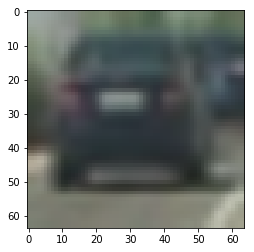

uint8
[156 168 163]


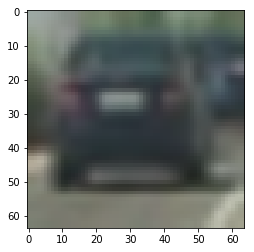

In [3]:
yolo = mpimg.imread(cars[0])
print(yolo.dtype)
print (yolo[0][0])
yolo_2 = (mpimg.imread(cars[0])*255).astype('uint8')
plt.imshow(yolo)
plt.show()
print(yolo_2.dtype)
print(yolo_2[0][0])
plt.imshow(yolo_2)
plt.show()
# #image = image.astype(np.float32)/255

**Define functions**

Create functions to use from Udacity Course

In [4]:

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        if '.png' in file:
            image = (mpimg.imread(file)*255).astype('uint8')
        else:
            image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    bbox_list = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bbox_list.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img, bbox_list

def final_heat(img, hot_windows):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, hot_windows)
    heat = apply_threshold(heat,1)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)

    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

In [5]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


In [6]:
sample_size = 8000
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32  # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, None] # Min and max in y to search in slide_window()

if 'car_features.p' in os.listdir('.'):
    with open('car_features.p', 'rb') as fp:
        car_features = pickle.load(fp)
    print('Loaded car features from file!')
else:
    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    with open('car_features.p', 'wb') as fp:
        pickle.dump(car_features, fp)
    print('Extracted car features and saved to file!')
    
if 'notcar_features.p' in os.listdir('.'):
    with open('notcar_features.p', 'rb') as fp:
        notcar_features = pickle.load(fp)
    print('Loaded non-car features from file!')
else:
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    with open('notcar_features.p', 'wb') as fp:
        pickle.dump(notcar_features, fp)
    print('Extracted non-car features and saved to file!')

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)
print('Using {} car images and {} non-car images'.format(len(cars), len(notcars)))
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
# model = LinearSVC()
# Check the training time for the SVC
t=time.time()
if 'model.sav' in os.listdir('.'):
    with open('model.sav', 'rb') as fp:
        model = pickle.load(fp)
    print('Model file already exists!')
else:
    model = LinearSVC()
    model.fit(X_train, y_train)
    with open('model.sav', 'wb') as fp:
        pickle.dump(model, fp)
    print('Model saved!')
    
# svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(model.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

# image = mpimg.imread('bbox-example-image.jpg')
# # image = image.astype(np.float32)/255
# draw_image = np.copy(image)

# # Uncomment the following line if you extracted training
# # data from .png images (scaled 0 to 1 by mpimg) and the
# # image you are searching is a .jpg (scaled 0 to 255)
# #image = image.astype(np.float32)/255

# windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
#                     xy_window=(96, 96), xy_overlap=(0.7, 0.7))
# print ('Number of search windows: {}'.format(len(windows)))

# hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
#                         spatial_size=spatial_size, hist_bins=hist_bins, 
#                         orient=orient, pix_per_cell=pix_per_cell, 
#                         cell_per_block=cell_per_block, 
#                         hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                         hist_feat=hist_feat, hog_feat=hog_feat)                       

# window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)

Loaded car features from file!
Loaded non-car features from file!
Using 8000 car images and 8000 non-car images
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6156
Model file already exists!
0.0 Seconds to train SVC...
Test Accuracy of SVC =  0.9988


C:\Users\cyran\.conda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


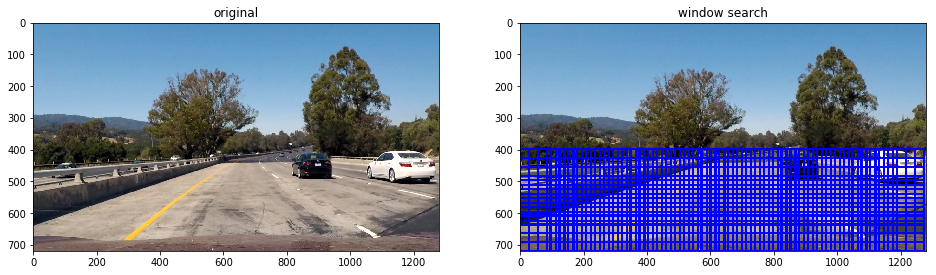

[((840, 400), (935, 495)), ((1120, 428), (1159, 495)), ((1176, 428), (1215, 523))]


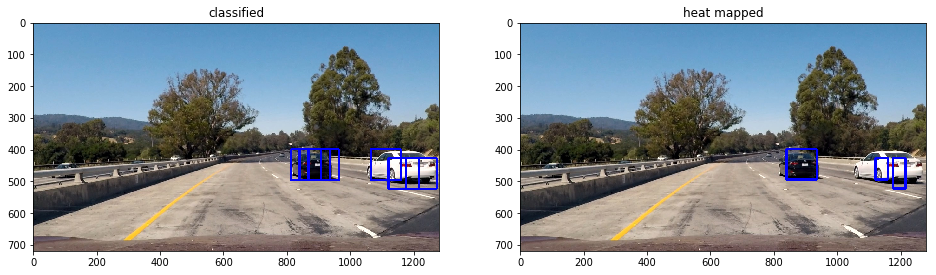

In [7]:
image = mpimg.imread('test_images/test1.jpg')
draw_image = np.copy(image)

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.7, 0.7))

hot_windows = search_windows(image, windows, model, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)

display_windows = draw_boxes(draw_image, windows, color=(0, 0, 255), thick=6)
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.title('original')
plt.imshow(image)
plt.subplot(122)
plt.title('window search')
plt.imshow(display_windows)
plt.show()

heat = np.zeros_like(image[:,:,0]).astype(np.float)
heat = add_heat(heat, hot_windows)
heat = apply_threshold(heat,1)
heatmap = np.clip(heat, 0, 255)
labels = label(heatmap)

draw_img, draw_box = draw_labeled_bboxes(np.copy(image), labels)

print(draw_box)

# draw_img = final_heat(image, hot_windows)
plt.figure(figsize=(16,8))

plt.subplot(121)
plt.title('classified')
plt.imshow(window_img)
plt.subplot(122)
plt.title('heat mapped')
plt.imshow(draw_img)
plt.show()

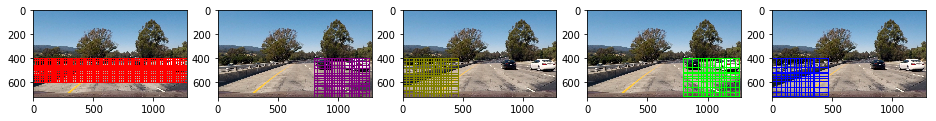

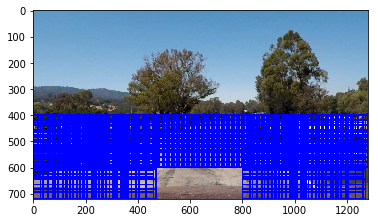

In [8]:
# Let's specify scaled search window sizes with respective to position in image

image = mpimg.imread('test_images/test1.jpg')

window_limits = ((64, 64), (96, 96), (96, 96), (128, 128), (128, 128))
y_limits = ([400, 600], [400, None], [400, None], [400, None], [400, None])
x_limits = ([None, None], [800, None], [0, 480], [800, None], [0, 480])
window_colors = ((255, 0, 0), (128, 0, 128), (128, 128, 0), (0, 255, 0), (0, 0, 255))
windows_total = []
plt.figure(figsize=(16,5))
iter_window = 1

for x_limit, y_limit, window_limit, color in zip(x_limits, y_limits, window_limits, window_colors):
    
    img = np.copy(image)
    
    windows = slide_window(image, x_start_stop=x_limit, y_start_stop=y_limit, 
                    xy_window=window_limit, xy_overlap=(0.7, 0.7))
    windows_total += windows
    
    display_windows = draw_boxes(img, windows, color=color, thick=6)
    
    plt.subplot(1,5,iter_window)
    plt.imshow(display_windows)
    
    iter_window += 1
    
plt.show()
display_windows = draw_boxes(img, windows_total, (0, 0, 255), thick=6)
plt.imshow(display_windows)
plt.show()

In [9]:
def scale_windows(image):
#     window_limits = ((48, 48), (128, 128), (128, 128))
#     y_limits = ([400, 500], [400, None], [400, None])
#     x_limits = ([None, None], [900, None], [0, 380])
#     window_colors = ((255, 0, 0), (0, 255, 0), (0, 0, 255))
    window_limits = ((64, 64), (96, 96), (96, 96), (128, 128), (128, 128))
    y_limits = ([400, 600], [400, None], [400, None], [400, None], [400, None])
    x_limits = ([None, None], [800, None], [0, 480], [800, None], [0, 480])
    window_colors = ((255, 0, 0), (128, 0, 128), (128, 128, 0), (0, 255, 0), (0, 0, 255))
    windows_total = []
#     plt.figure(figsize=(16,5))
    iter_window = 1

    for x_limit, y_limit, window_limit, color in zip(x_limits, y_limits, window_limits, window_colors):

        img = np.copy(image)

        windows = slide_window(image, x_start_stop=x_limit, y_start_stop=y_limit, 
                        xy_window=window_limit, xy_overlap=(0.7, 0.7))
        windows_total += windows

#         display_windows = draw_boxes(img, windows, color=color, thick=6)

#         plt.subplot(1,3,iter_window)
#         plt.imshow(display_windows)

#         iter_window += 1
    
    return windows_total

C:\Users\cyran\.conda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


test_images\test1.jpg


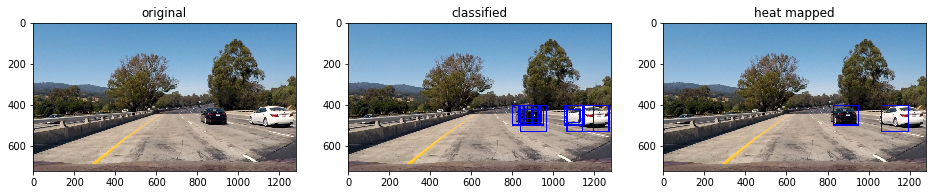

test_images\test2.jpg


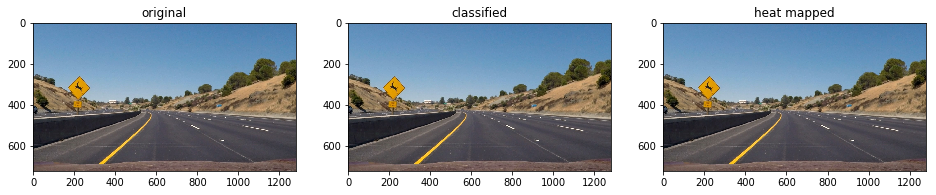

test_images\test3.jpg


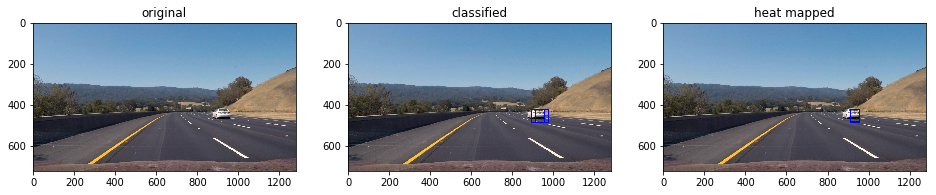

test_images\test4.jpg


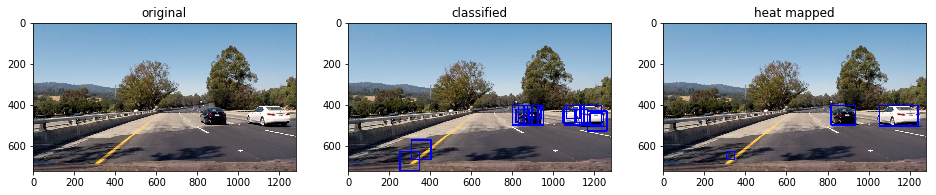

test_images\test5.jpg


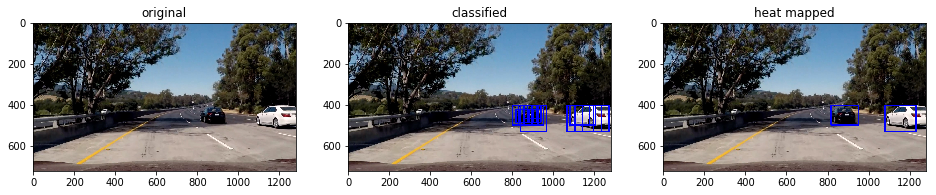

test_images\test6.jpg


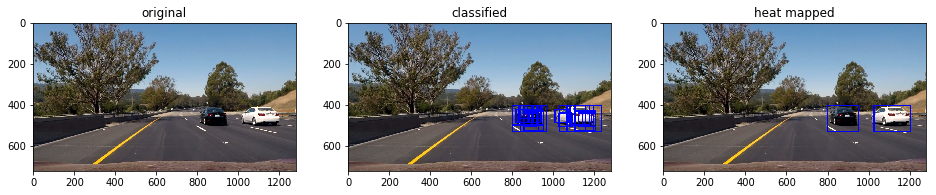

In [10]:
# Let's try the classifier in test image
test_images = glob.glob('test_images/*')
n_images = len(test_images)



for i, pic in enumerate(test_images):
    
    img = mpimg.imread(pic)
    draw_img = np.copy(img)
    
    windows = scale_windows(draw_img)

    hot_windows = search_windows(img, windows, model, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_img, hot_windows, color=(0, 0, 255), thick=6)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, hot_windows)
    heat = apply_threshold(heat,1)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)

    heat_img, box_list = draw_labeled_bboxes(np.copy(img), labels)
    
    print (pic.replace('test_images/', ""))
    plt.figure(figsize=(16,8))
    plt.subplot(1, 3, 1)
    plt.title('original')
    plt.imshow(img)
    plt.subplot(1, 3, 2)
    plt.title('classified')
    plt.imshow(window_img)
    plt.subplot(1, 3, 3)
    plt.title('heat mapped')
    plt.imshow(heat_img)
    plt.show()



C:\Users\cyran\.conda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


[((817, 400), (937, 495)), ((1052, 400), (1241, 501)), ((308, 624), (347, 663))]


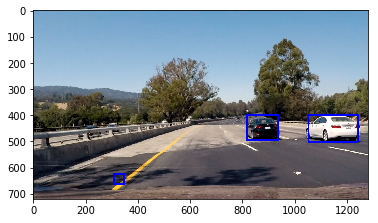

In [11]:
test_image = mpimg.imread('test_images/test4.jpg')

def pipeline(img):
    draw_img = np.copy(img)
    
    windows = scale_windows(img)
    
    hot_windows = search_windows(img, windows, model, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
#     print(hot_windows)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, hot_windows)
    heat = apply_threshold(heat,1)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)

    draw_img, box_list = draw_labeled_bboxes(np.copy(img), labels)
    
#     print(box_list[0])
    
    final_img = final_heat(img, hot_windows)
    
    return final_img, box_list

output, box_list = pipeline(test_image)[0]
print (box_list)
plt.imshow(output)
plt.show()

In [ ]:
from collections import deque

class Vehicle():
    
    def __init__(self):
        
        self.detected = False
        
        self.n_detections = 0
        
        self.n_nondetections = 0
        
        self.history = 0
        
        self.heatbox = None
        
        self.heatbox_list = deque(maxlen=10)
        
        self.avg_heatbox = None
        
    def process_image(self, img):
        
        draw_img = np.copy(img)
        
        windows = scale_windows(img)
        
        hot_windows = search_windows(img, windows, model, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
        
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        heat = add_heat(heat, hot_windows)
        heat = apply_threshold(heat,1)
        heatmap = np.clip(heat, 0, 255)
#         labels = label(heatmap)

#         dum_img, box_list = draw_labeled_bboxes(np.copy(img), labels)
        
#         if self.history < 10:
        self.heatbox_list.append(heatmap)
        self.history = len(self.heatbox_list)
        self.heatbox = heatmap
#         print(self.heatbox_list)
#         print(self.history)
        self.avg_heatbox = np.mean(self.heatbox_list, axis=0)
        if self.history == 10:
            labels = label(self.avg_heatbox)
            output, box_list = draw_labeled_bboxes(np.copy(img), labels)
#             output = draw_boxes(draw_image, avg_heatbox, color=(0, 0, 255), thick=6)
        else:
            labels = label(heatmap)
            output, box_list = draw_labeled_bboxes(np.copy(img), labels)
            
        return output
            

In [ ]:
tracker = Vehicle()
from moviepy.editor import VideoFileClip

def process_video (input_path, output_path):
    clip = VideoFileClip (input_path)
    result = clip.fl_image(tracker.process_image)
    %time result.write_videofile (output_path, audio=False)

process_video('test_video.mp4', 'test_video_result.mp4')
# process_video ('project_video.mp4', 'project_video_result.mp4')
# process_video ('challenge_video.mp4', 'challenge_video_result.mp4')
# process_video ('harder_challenge_video.mp4', 'harder_challenge_video_result.mp4')

[MoviePy] >>>> Building video test_video_result.mp4
[MoviePy] Writing video test_video_result.mp4


 41%|█████████             | 16/39 [01:41<02:22,  6.21s/it]